# Eigenfaces

##### Diego Alba, AMATH 563, 5/2020

### Abstract:

The goal of this assignment is to 

### Background

The first dataset, concerning Canadian lynx and snowshoe hare populations from 1845 to 1903, contains 30 pairs of datapoints. We will see that in order to use some of the methods we will have to interpolate between the data to generate more points. The second dataset contains 1200 images of the Belousov-Zhabotinsky chemical oscillator.

The main model discovery techniqiue in this assignment will be Dynamic Mode Decomposition (DMD). The idea here is to find the best linear approximation to the dynamical system by projecting into a low rank space that captures the most important feattues (dynamic modes) of the system. This allows for good near-future predictions, and beacuse of cheap computations, it can be performed real time.

In order to apply DMD to cases with a small amout of data, or where not all variables are know, one can do time delay embeddings. That is, to make new variables from the ones available by shifting them in time. Similarly, another embedding technique is to apply a library of functions, such as polynomials, to the original data. Both techniques are able to find more accurate dynamical modes. Moreover, these versions of DMD can be coupled with regularization schemas such as L1 in order to promote sparsity and make the dynamic modes more interpretable.

To compare results we use several statistics. Kullback–Leibler divergence (KL divergence) is related to the Shanon entropy as measure of information or suprise and compares the similarity between a probablity distribution and a reference probability distribution. Akaike information criterion (AIC) is a measure that tries to compare models by not only contrasting the errors but also the number of parameters. Lastly, Bayesian information criterion (BIC) is similar to AIC, but with a different penalty for the number of parameters That is, with AIC the penalty is 2k, whereas with BIC the penalty is ln(n)k.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import HTML
print("HTML Settings, don't know how to remove these two blocks")
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: center;
}
</style>
""")

HTML Settings, don't know how to remove these two blocks


In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split as ttsplit
from sklearn.metrics.pairwise import cosine_similarity as cossim
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


### Implementation and Results

The fist thing we'll set up some settings for the Jupyter notebook and import all of the packages required to carry out the analysis and plotting.

We load the data and interpolate. This is depicted in Figure 1. 

STRAT W CROPPED

In [6]:
cwd = os.getcwd()
r = '../CroppedYale/'
dirs = os.listdir(r)
cropped = []
total = 0
for d in dirs:
    files = os.listdir(r+d)
    imgs = np.zeros((len(files),192,168))
    for k,f in enumerate(files):
        imgs[k] = np.array(Image.open(r+d+'/'+f))
        total = total+1
    cropped.append(imgs)

                               Figure 1


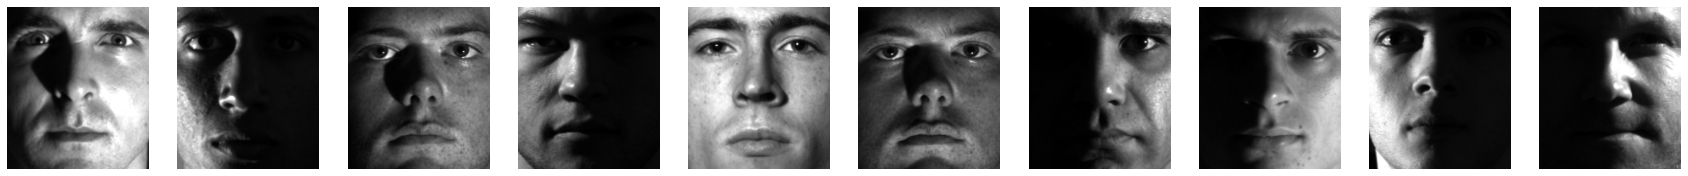

In [7]:
plt.figure(figsize=(30,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(cropped[np.random.randint(len(dirs))][np.random.randint(total/len(dirs))], 'gray')
    plt.axis('off')
print('                               Figure 1')

In [8]:
k = 0
Y = []
G = []
allimgs = []
for c in cropped:
    n,x,y=c.shape
    newimgs = np.reshape(c,(n,x*y)).T
    if k != 0:
        allimgs = np.concatenate([allimgs,newimgs],axis=1)
    else: allimgs = newimgs
    if k in [4, 14, 21, 26, 27, 31, 33, 36]: G.extend([1]*n)
    else: G.extend([0]*n)
    Y.extend([k]*n)
    k=k+1

In [10]:
U,S,Vh = np.linalg.svd(allimgs,full_matrices = False)

                               Figure 2


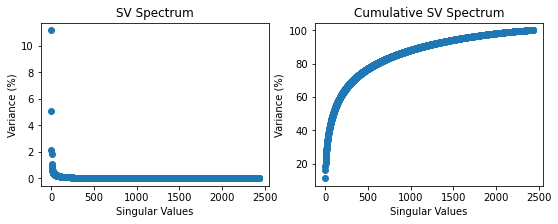

In [11]:
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.plot((S/np.sum(S))*100,'o')
plt.xlabel('Singular Values')
plt.ylabel('Variance (%)')
plt.title('SV Spectrum')

plt.subplot(122)
plt.plot(np.cumsum(S/np.sum(S))*100,'o')
plt.xlabel('Singular Values')
plt.ylabel('Variance (%)')
plt.title('Cumulative SV Spectrum')
print('                               Figure 2')

In [12]:
sv10 = (U[:,:10] * S[:10]) @ Vh[:10,:]
sv500 = (U[:,:500] * S[:500]) @ Vh[:500,:]

                               Figure 3


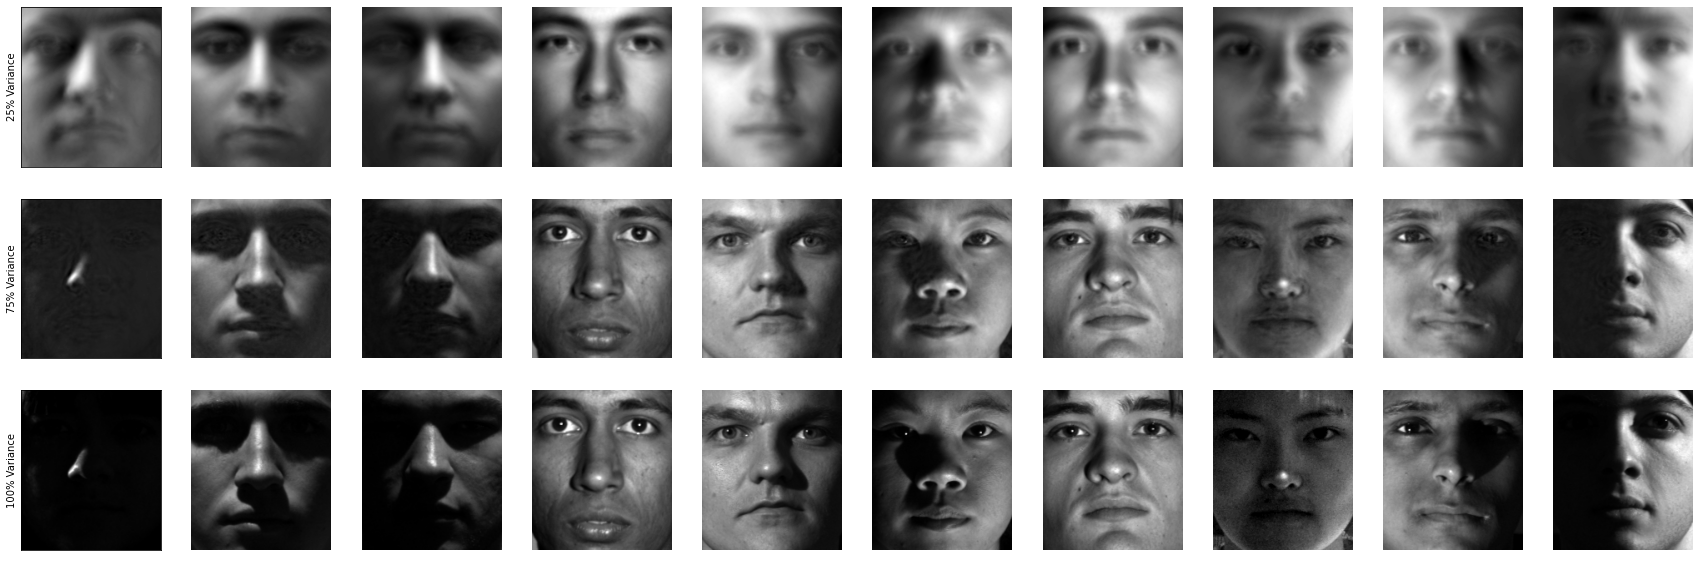

In [14]:
plt.figure(figsize=(30,10))
for i in range(10):
    k = np.random.randint(total)
    plt.subplot(3,10,i+1)
    plt.imshow(np.reshape(sv10[:,k],(x,y)),'gray')
    if i == 0: plt.ylabel('25% Variance'); plt.yticks([]), plt.xticks([])
    else: plt.axis('off')

    plt.subplot(3,10,i+11)
    plt.imshow(np.reshape(sv500[:,k],(x,y)),'gray')
    if i == 0: plt.ylabel('75% Variance'); plt.yticks([]), plt.xticks([])
    else: plt.axis('off')
        
    plt.subplot(3,10,i+21)
    plt.imshow(np.reshape(allimgs[:,k],(x,y)),'gray')
    if i == 0: plt.ylabel('100% Variance'); plt.yticks([]), plt.xticks([])
    else: plt.axis('off')
print('                               Figure 3')

In [15]:
r = '../yalefaces/'
files = os.listdir(r)
subjects = np.unique([f.split('.')[0] for f in files])
uncropped = []
total = 0
for k,s in enumerate(subjects):
    i=0
    imgs = np.zeros((len(files)//len(subjects),243,320))
    for f in files:
        if s in f:
            imgs[i] = np.array(Image.open(r+f))
            total = total+1; i=i+1
    uncropped.append(imgs)

                               Figure 4


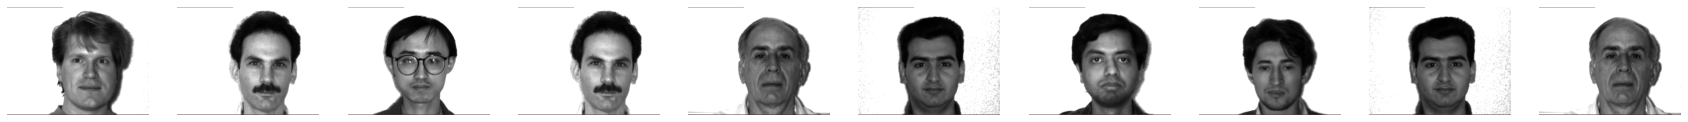

In [16]:
plt.figure(figsize=(30,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(uncropped[np.random.randint(len(subjects))][np.random.randint(total/len(files))], 'gray')
    plt.axis('off')
print('                               Figure 4')

In [17]:
k = 0
oldimgs = []
for c in uncropped:
    n,x,y=c.shape
    newimgs = np.reshape(c,(n,x*y)).T
    if k != 0:
        oldimgs = np.concatenate([oldimgs,newimgs],axis=1)
    else: oldimgs = newimgs; k =1

In [18]:
U,S,Vh = np.linalg.svd(oldimgs,full_matrices = False)

                               Figure 5


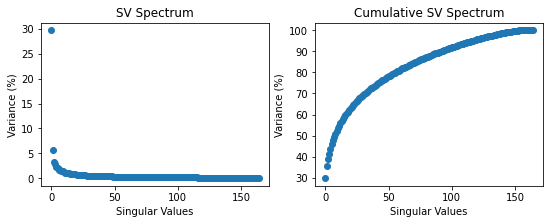

In [19]:
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.plot((S/np.sum(S))*100,'o')
plt.xlabel('Singular Values')
plt.ylabel('Variance (%)')
plt.title('SV Spectrum')

plt.subplot(122)
plt.plot(np.cumsum(S/np.sum(S))*100,'o')
plt.xlabel('Singular Values')
plt.ylabel('Variance (%)')
plt.title('Cumulative SV Spectrum')
print('                               Figure 5')

In [20]:
sv10 = (U[:,:8] * S[:8]) @ Vh[:8,:]
sv500 = (U[:,:70] * S[:70]) @ Vh[:70,:]

                               Figure 6


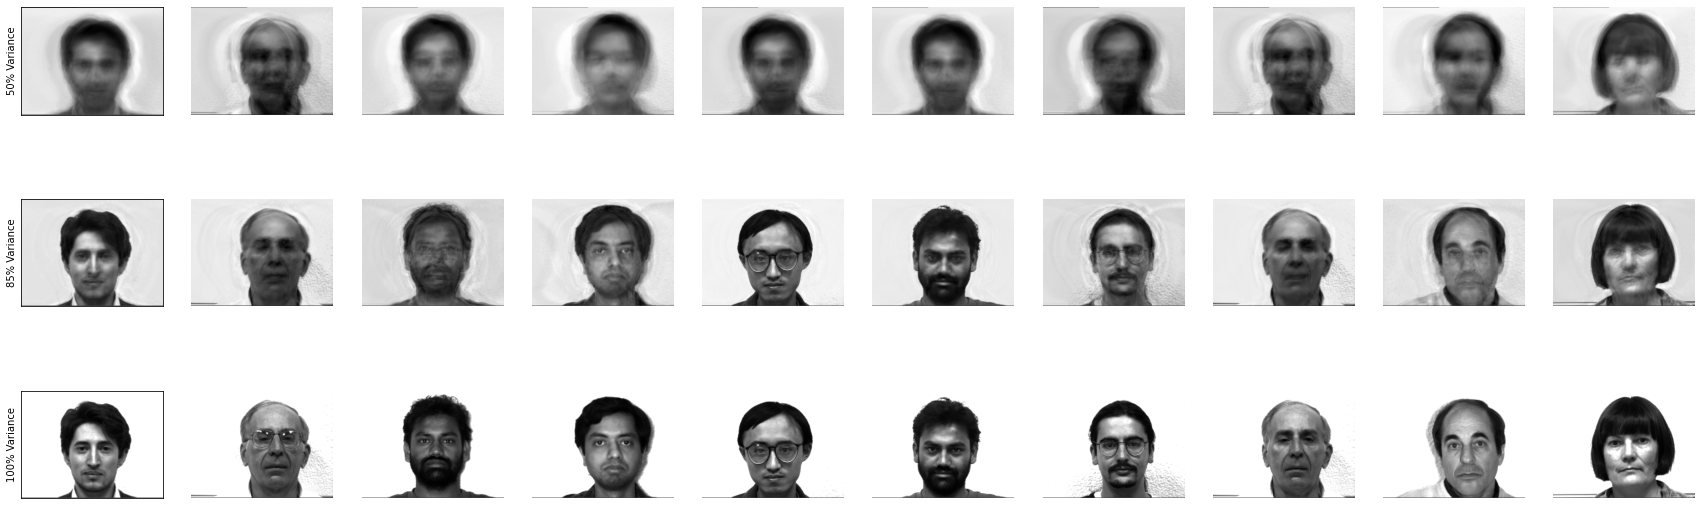

In [21]:
plt.figure(figsize=(30,10))
for i in range(10):
    k = np.random.randint(total)
    plt.subplot(3,10,i+1)
    plt.imshow(np.reshape(sv10[:,k],(x,y)),'gray')
    if i == 0: plt.ylabel('50% Variance'); plt.yticks([]), plt.xticks([])
    else: plt.axis('off')

    plt.subplot(3,10,i+11)
    plt.imshow(np.reshape(sv500[:,k],(x,y)),'gray')
    if i == 0: plt.ylabel('85% Variance'); plt.yticks([]), plt.xticks([])
    else: plt.axis('off')
        
    plt.subplot(3,10,i+21)
    plt.imshow(np.reshape(oldimgs[:,k],(x,y)),'gray')
    if i == 0: plt.ylabel('100% Variance'); plt.yticks([]), plt.xticks([])
    else: plt.axis('off')
print('                               Figure 6')

                               Figure 4


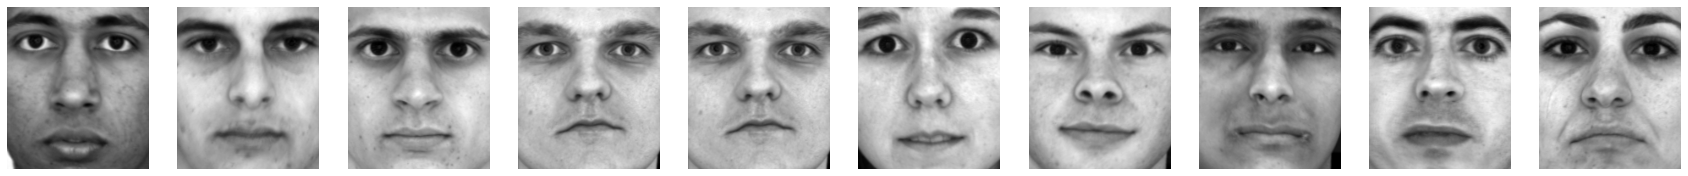

In [22]:
meanface = np.zeros((len(cropped),192,168))
for k,c in enumerate(cropped):
    meanface[k] = np.mean(c,axis=0)

k = 0
oldimgs = []
for c in meanface:
    x,y=c.shape
    newimgs = np.reshape(c,(1,x*y)).T
    if k != 0:
        oldimgs = np.concatenate([oldimgs,newimgs],axis=1)
    else: oldimgs = newimgs; k =1

plt.figure(figsize=(30,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(meanface[np.random.randint(len(meanface))], 'gray')
    plt.axis('off')
print('                               Figure 4')

In [23]:
x_train,x_test, y_train,y_test,g_train,g_test = ttsplit(allimgs.T,np.array(Y),np.array(G),test_size = 0.2)
x_train = x_train.T; x_test = x_test.T

subjmean = np.zeros((len(allimgs),np.max(Y)))
for i in range(np.max(Y)):
    subjmean[:,i] = np.mean(x_train[:,y_train == i],axis=1)

gmean = np.zeros((len(allimgs),2))
for i in range(2):
    gmean[:,i] = np.mean(x_train[:,g_train == i],axis=1)
    
mean = np.mean(x_train,axis=1)
X = np.array(subjmean-np.tile(mean,(subjmean.shape[1],1)).T)

In [24]:
U,S,Vh = np.linalg.svd(X,full_matrices = False)

                               Figure 5


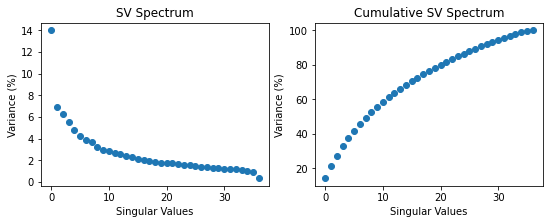

In [25]:
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.plot((S/np.sum(S))*100,'o')
plt.xlabel('Singular Values')
plt.ylabel('Variance (%)')
plt.title('SV Spectrum')

plt.subplot(122)
plt.plot(np.cumsum(S/np.sum(S))*100,'o')
plt.xlabel('Singular Values')
plt.ylabel('Variance (%)')
plt.title('Cumulative SV Spectrum')
print('                               Figure 5')

                               Figure 6


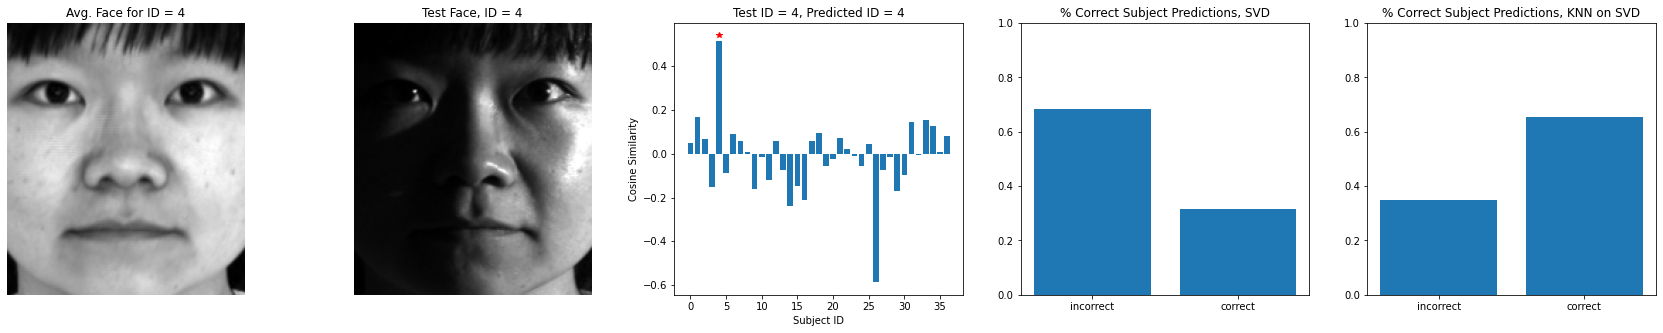

In [79]:
ID = 456
plt.figure(figsize=(30,5))

plt.subplot(151)
plt.imshow(np.reshape(subjmean[:,y_test[ID]],(x,y)),'gray')
plt.title('Avg. Face for ID = '+str(y_test[ID]))
plt.axis('off')

plt.subplot(152)
plt.imshow(np.reshape(x_test[:,ID],(x,y)),'gray')
plt.title('Test Face, ID = '+str(y_test[ID]))
plt.axis('off')

plt.subplot(153)
key = (x_test[:,ID]-mean) @ U
compare = cossim(key.reshape(1, -1),Vh.T).squeeze()
plt.bar(np.arange(np.max(Y)),compare)
plt.plot(np.argmax(compare),np.max(compare)*1.05,'r*')
plt.xlabel('Subject ID')
plt.ylabel('Cosine Similarity')
plt.title('Test ID = '+str(y_test[ID])+', Predicted ID = '+str(np.argmax(compare)));

correct = 0
total = len(y_test)
for i in range(total):
    key = (x_test[:,i]-mean) @ U
    compare = cossim(key.reshape(1, -1),Vh.T).squeeze()
    if y_test[i] == np.argmax(compare): correct = correct + 1

plt.subplot(154)
plt.bar([0,1],[1-correct/total,correct/total])
plt.xticks([0,1],['incorrect','correct'])
plt.ylim([0,1])
plt.title('% Correct Subject Predictions, SVD')

classifier = knn(n_jobs=-1)
classifier.fit(x_train.T,y_train)
y_hat = classifier.predict(x_test.T)
correct = np.sum(y_hat==y_test)

plt.subplot(155)
plt.bar([0,1],[1-correct/total,correct/total])
plt.xticks([0,1],['incorrect','correct'])
plt.ylim([0,1])
plt.title('% Correct Subject Predictions, KNN')
print('                               Figure 6')

In [135]:
correct = []
for i in np.arange(3,30,3):
    classifier = knn(n_neighbors = i, n_jobs=-1)
    classifier.fit(x_train.T,y_train)
    y_hat = classifier.predict(x_test.T)
    correct.append(np.sum(y_hat==y_test))

ValueError: Found input variables with inconsistent numbers of samples: [32256, 1945]

In [129]:
kcorrect = []
for i in range(5):
    x_train,x_test, y_train,y_test = ttsplit(allimgs.T,np.array(Y),test_size = 0.2)
    classifier = knn(n_jobs=-1)
    classifier.fit(x_train,y_train)
    y_hat = classifier.predict(x_test)
    kcorrect.append(np.sum(y_hat==y_test))

                               Figure 6


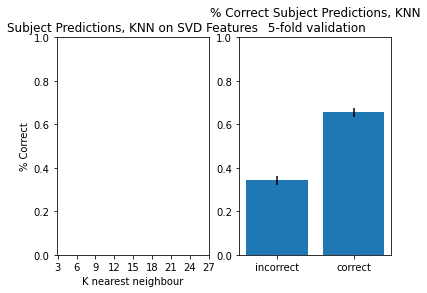

In [134]:
plt.subplot(121)
plt.plot(np.array(correct)/total)
plt.ylim([0,1])
plt.xticks(range(len(np.arange(3,30,3))),np.arange(3,30,3))
plt.xlabel('K nearest neighbour')
plt.title('Subject Predictions, KNN')
plt.ylabel('% Correct')

kc = np.array(kcorrect)
plt.subplot(122)
plt.bar([0,1],[1-np.mean(kc)/total,np.mean(kc)/total], yerr=[np.std(kc)/total]*2)
plt.xticks([0,1],['incorrect','correct'])
plt.ylim([0,1])
plt.title('% Correct Subject Predictions, KNN\n 5-fold validation')
print('                               Figure 6')

In [241]:
U,S,Vh = np.linalg.svd(gmean,full_matrices = False)

                               Figure 7


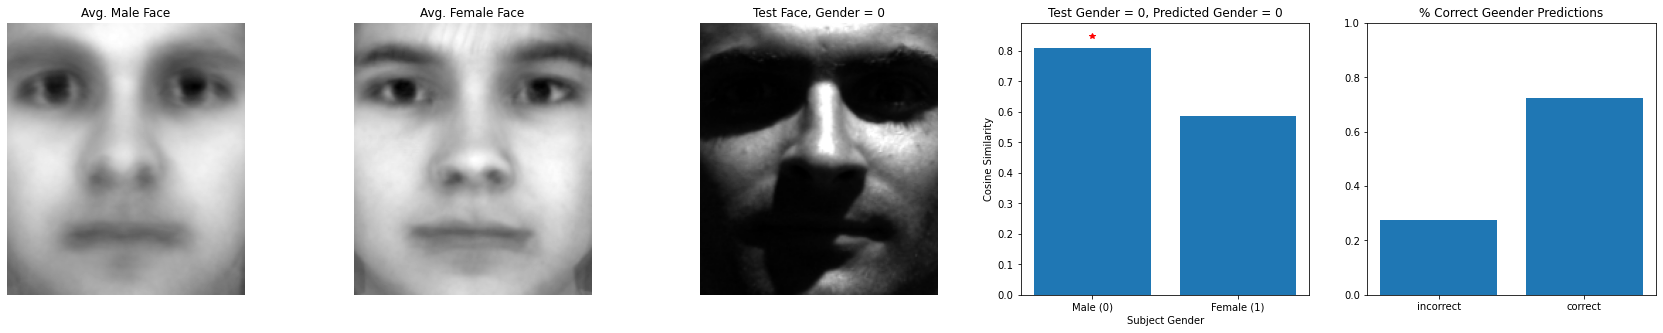

In [254]:
ID = np.random.randint(len(g_test))
plt.figure(figsize=(30,5))
plt.subplot(151)
plt.imshow(np.reshape(gmean[:,0],(x,y)),'gray')
plt.title('Avg. Male Face')
plt.axis('off')

plt.subplot(152)
plt.imshow(np.reshape(gmean[:,1],(x,y)),'gray')
plt.title('Avg. Female Face')
plt.axis('off')

plt.subplot(153)
plt.imshow(np.reshape(x_test[:,ID],(x,y)),'gray')
plt.title('Test Face, Gender = '+str(g_test[ID]))
plt.axis('off')

plt.subplot(154)
key = (x_test[:,ID]) @ U
compare = cossim(key.reshape(1, -1),Vh.T).squeeze()
plt.bar(np.arange(np.max(G)+1),compare)
plt.plot(np.argmax(compare),np.max(compare)*1.05,'r*')
plt.xlabel('Subject Gender')
plt.ylabel('Cosine Similarity')
plt.title('Test Gender = '+str(g_test[ID])+', Predicted Gender = '+str(np.argmax(compare)));
plt.xticks([0,1],['Male (0)','Female (1)'])


correct = 0
total = len(g_test)
for i in range(total):
    key = (x_test[:,i]) @ U
    compare = cossim(key.reshape(1, -1),Vh.T).squeeze()
    if g_test[i] == np.argmax(compare): correct = correct + 1

plt.subplot(155)
plt.bar([0,1],[1-correct/total,correct/total])
plt.xticks([0,1],['incorrect','correct'])
plt.ylim([0,1])
plt.title('% Correct Geender Predictions')

print('                               Figure 7')

Switching gears to the Belousov-Zhabotinsky chemical oscillator dataset. We load the data and display 10 images at different time points in Figure 7.

We can observe that in this case both DMD and time-delay DMD are very good, both when fitting to the training set and predicting the test set. This is porbably because the amount of data is much larger than in the Canadian lynx and snowshoe hare populations dynamics dataset.

### Conlcusion

We have shown how to use different DMD variations for data-driven system identification for two very different datasets. Particularly, we have seen that the algorithm time-delay embedding is incredibly very useful when theres limited amounts of data or only a few variables have been measured. Moreover, we have shown how to compare moedls with different statistical score, such as KL divergence.

### Appendix

The full Jupyter Notebook containing the report and the code used can be found at https://github.com/DIEGOA363/ISCS